#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# отключим предупреждающие уведомления
import warnings
warnings.filterwarnings('ignore')

# Добавим основные библиотеки
import pandas as pd
import numpy as np
import os.path

# Добавим библиотеки для отрисовки графиков
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# добавим необходимые библиотеки для построения моделей
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Сделаем небольшие настройки pandas для комфортного отображения проекта
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [2]:
# Импортируем датасеты методом try/except и установим индексом столбец date
try:
    path_df = os.path.join('datasets/taxi.csv', index_col=[0], parse_dates=[0])
    df = pd.read_csv(path_df)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)
df = df.resample('1H').sum()

## Анализ

Взглянем на общую информацию по датасету

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


4416 записей с 1 марта по 31 августа 2018-го года, пропусков нет

Взглянем на описательную статистику

In [4]:
df.describe()

,num_orders
count,4416.00
mean,84.42
std,45.02
min,0.00
25%,54.00
50%,78.00
75%,107.00
max,462.00


- максимальное количество вызовов за час составляло 462 вызона, 
- минимальное 0
- стандартное отклонение 45 вызовов

Посмотрим на временной ряд

<Axes: title={'center': 'Временной ряд по заказам'}, xlabel='datetime'>

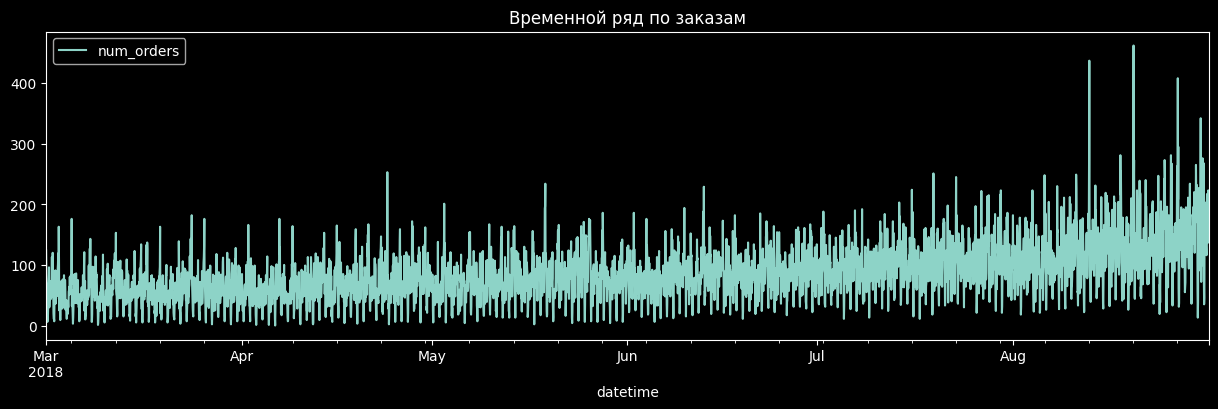

In [5]:
df.plot(figsize=(15,4), title='Временной ряд по заказам')

Выглядит слишком шумно, посмотрим на скользящее среднее за сутки

<Axes: title={'center': 'Временной ряд по заказам (скользящее среднее за сутки)'}, xlabel='datetime'>

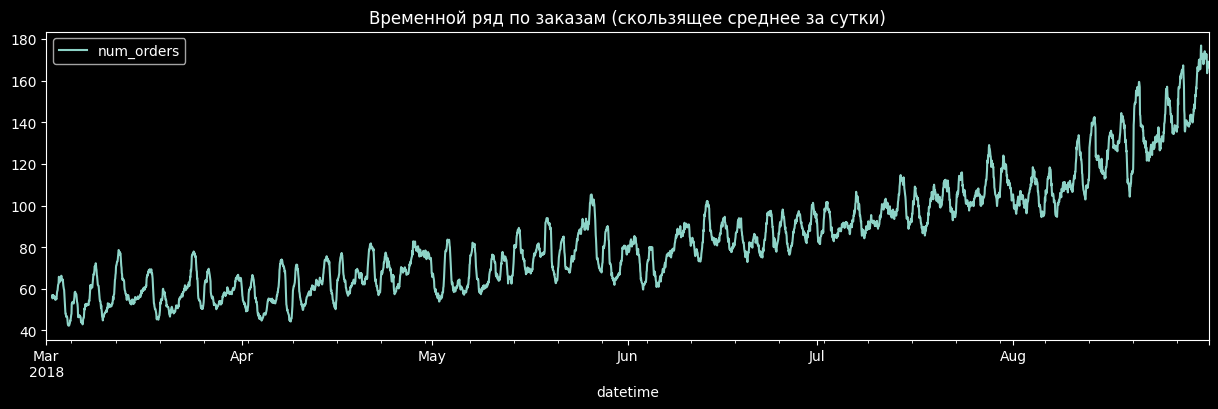

In [6]:
df.rolling(24).mean().plot(figsize=(15,4), title='Временной ряд по заказам (скользящее среднее за сутки)')

посмотрим за месяц

<Axes: title={'center': 'Временной ряд по заказам (скользящее среднее за месяц)'}, xlabel='datetime'>

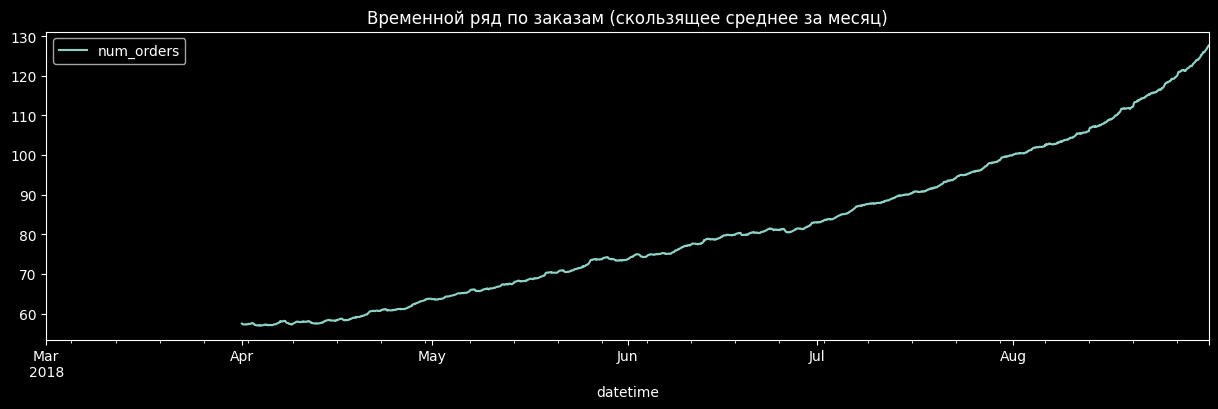

In [7]:
df.rolling(24*31).mean().plot(figsize=(15,4), title='Временной ряд по заказам (скользящее среднее за месяц)')

Взглянем на декомпозицию трендов и сезонности

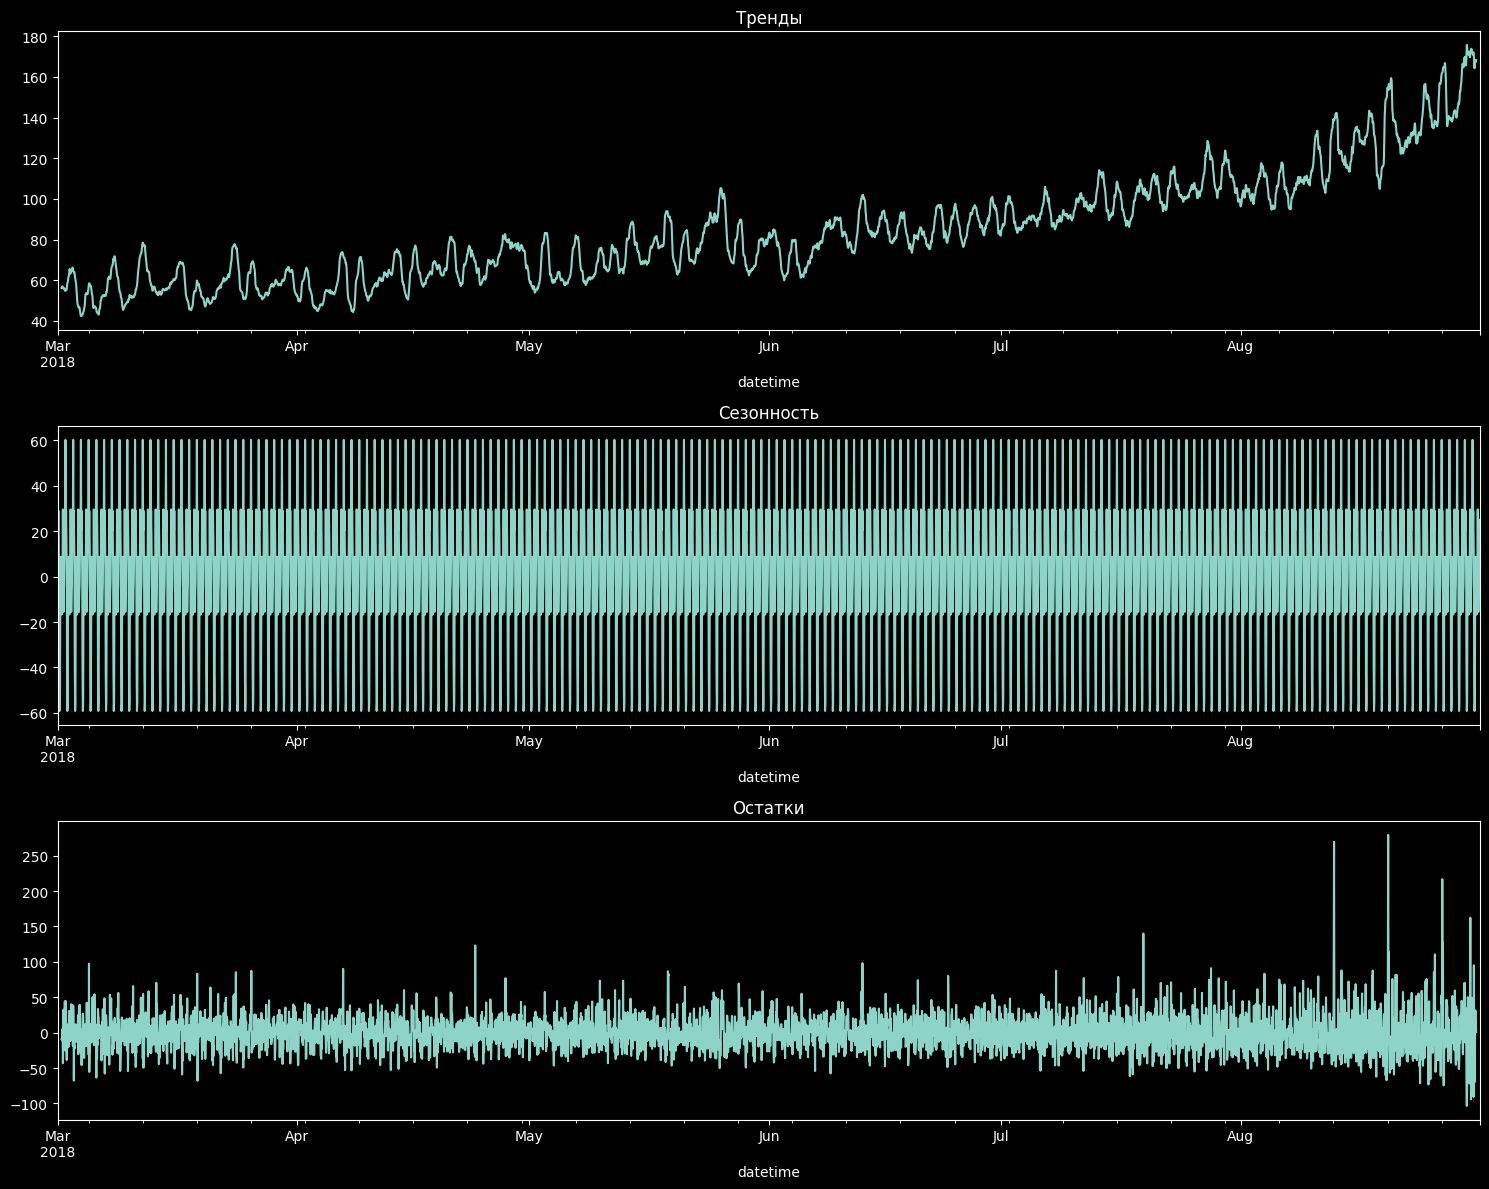

In [8]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренды')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

приблизим масштаб

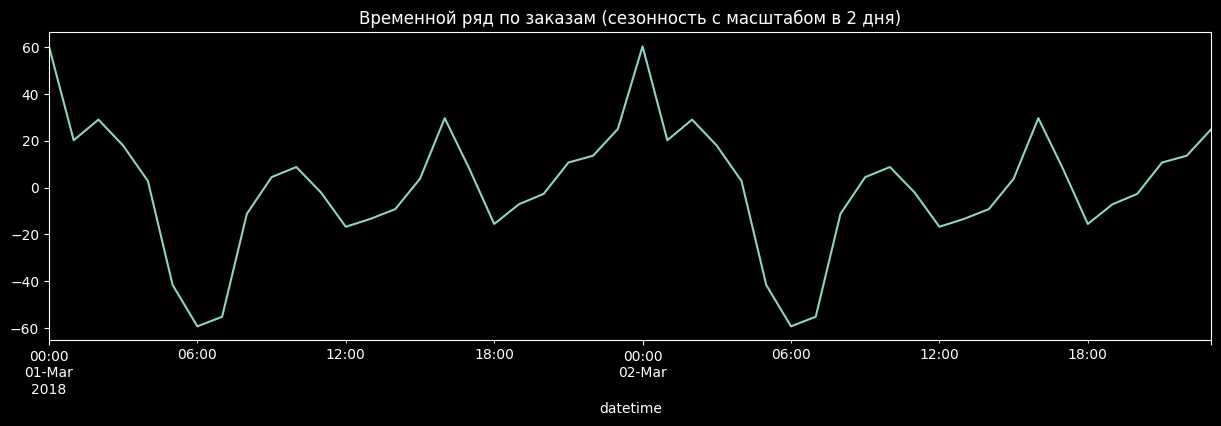

In [9]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15, 4), title='Временной ряд по заказам (сезонность с масштабом в 2 дня)');

- Виден возрастающий тренд с ускорением плавно нарастающим экпоненциально за весь наблюдаемый период
- Виден посуточный стационарный ряд, к 12 ночи заказы возрастают, к 7 утра падают до минимума, ещё небольшие пики около 10:00 и 17:00
- Дисперсия остатков со временем увеличивается, шума в конце наблюдаемого периода становится больше

## Обучение

Напишем функцию по созданию признаков

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Посмотрим по автокорреляции на значимость лагов

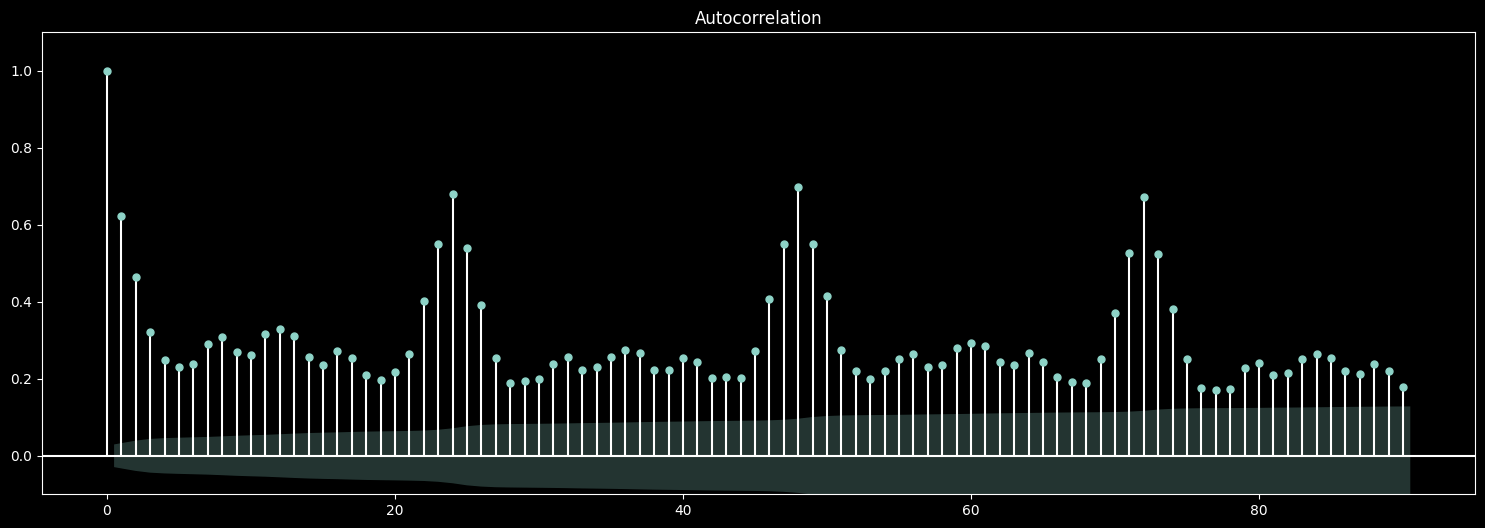

In [11]:
fig = tsaplots.plot_acf(df['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Создадим признаки с лагами за неделю и скользящей за сутки

In [12]:
make_features(df, 168, 24)

In [13]:
# разабьём датасет на выборки
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Создадим объект кроссвалидации `TimeSeriesSplit`

In [14]:
tscv = TimeSeriesSplit(n_splits=10)

## DecisionTreeRegressor

выполним поиск гиперпараметров для `DecisionTreeRegressor` с помощью `GridSearchCV`

In [15]:
dt_params = {'max_depth':[x for x in range(2, 21)]}
dt_model = DecisionTreeRegressor(random_state=1337) 

dt_gsearch = GridSearchCV(estimator=dt_model, cv=tscv, param_grid=dt_params, scoring='neg_mean_squared_error', error_score='raise')
dt_gsearch.fit(X_train, y_train)

dt_rmse = round(abs(dt_gsearch.best_score_)**0.5, 4)

print('Лучшие результаты модели DecisionTreeRegressor на кросс валидации')
print('RMSE =', dt_rmse)
print()
print('при параметрах')
print(dt_gsearch.best_params_)

Лучшие результаты модели DecisionTreeRegressor на кросс валидации
RMSE = 24.179

при параметрах
{'max_depth': 4}


## CatBoost

выполним поиск гиперпараметров для `CatBoost` с помощью `GridSearchCV`

In [16]:
cb_params = {'learning_rate':[0.01,0.02,0.03,0.06,0.1,0.2,0.3]}
cb_model = CatBoostRegressor(verbose=False,
                             random_state=1337)

cb_gsearch = GridSearchCV(estimator=cb_model, cv=tscv, param_grid=cb_params, scoring='neg_mean_squared_error')
cb_gsearch.fit(X_train, y_train)

cb_rmse = round(abs(cb_gsearch.best_score_)**0.5, 4)

print('Лучшие результаты модели CatBoostRegressor на кросс валидации')
print('RMSE =', cb_rmse)
print()
print('при параметрах')
print(cb_gsearch.best_params_)

Лучшие результаты модели CatBoostRegressor на кросс валидации
RMSE = 20.4555

при параметрах
{'learning_rate': 0.01}


In [17]:
comparison = pd.DataFrame({'модель': ['DecisionTreeRegressor','CatBoostRegressor'],
                           'RMSE':[dt_rmse, cb_rmse]})
comparison

,модель,RMSE
0,DecisionTreeRegressor,24.18
1,CatBoostRegressor,20.46


Модель `CatBoostRegressor` на кросс валидации показала результат лучше

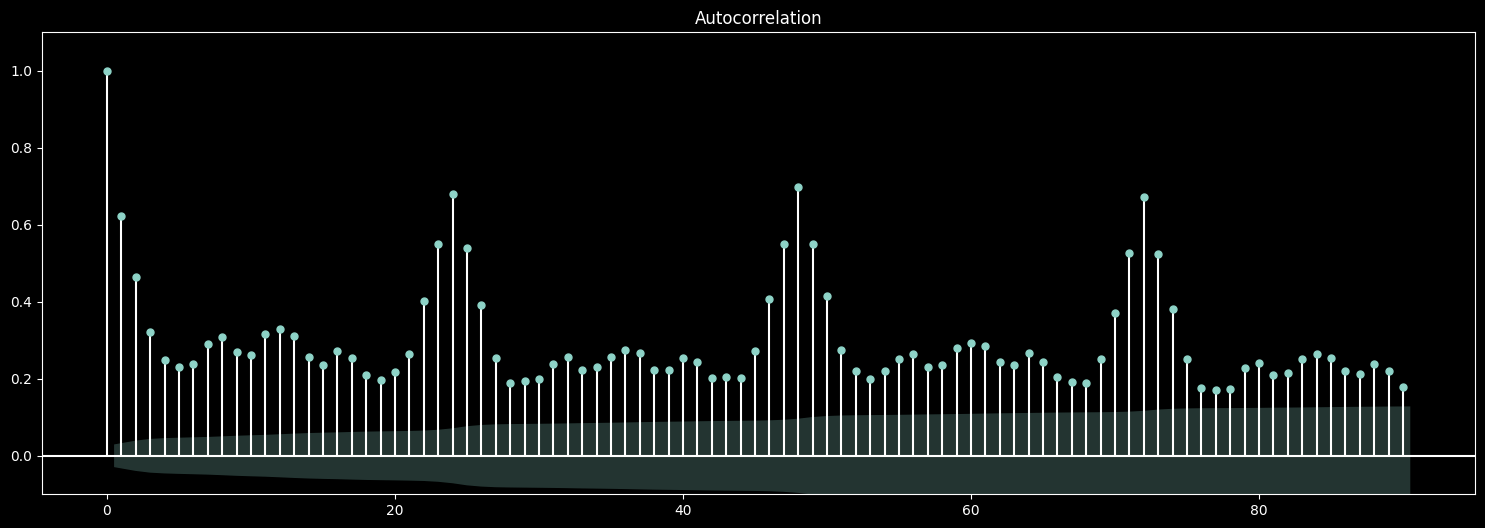

In [18]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(df['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



## Тестирование

In [19]:
model = CatBoostRegressor(verbose=False,
                          random_state=1337,
                          learning_rate=0.01
                          )
model.fit(X_train, y_train)

In [20]:
predict_test = model.predict(X_test)
rmse = mean_squared_error(y_test, predict_test)**0.5
print("RMSE тестовой выборки: ", rmse)

RMSE тестовой выборки:  39.168062874918384


## Проверим модель на адекватность

Для проверки возмём предсказания основанные на предыдущем измерении

In [21]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

dummy_rmse = mean_squared_error(y_test, pred_previous)**0.5
print('Dummy RMSE: ', dummy_rmse)

Dummy RMSE:  53.36807644753937


Вывод:
- данные импортированы и проанализированны
- Модель градиентного бустинга обучена
- RMSE > 48 получено
- Проверку на адекватность модель проходит